# MNIST Dataset: Density Forests
Trains a simple CNN on _N-1_ classes of the MNIST dataset, predicts unseen classes using baseline methods and Density Forest.

In [1]:
# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
#import libraries
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn import decomposition, svm, metrics
from tensorflow.python.client import device_lib



#custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich')  # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from density_forest.density_forest import *
from density_forest.plots import *
from density_forest.helpers import *
from baselines.helpers import *
from helpers.helpers import *
from helpers.plots import *
from helpers.cv_scorers import *
from helpers.cross_validator import ParameterSearch
from parametric_tSNE.utils import *

# print available devices
print(device_lib.list_local_devices())

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2521885589927692312
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10905383732
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 6148060293005303843
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [3]:
label_to_remove = 6

# the data, shuffled and split between train and test sets
def load_data(label_to_remove):
    (x_train_all, y_train_all), (x_test_all, y_test_all) = mnist.load_data()
    print(np.unique(y_train_all, return_counts=True))



    # remove all trainig samples containing a label label_to_remove
    x_train = x_train_all[y_train_all != label_to_remove]
    y_train = y_train_all[y_train_all != label_to_remove]

    x_test = x_test_all[y_test_all != label_to_remove]
    y_test = y_test_all[y_test_all != label_to_remove]

    # decrease all labels that are higher by -1 to avoid gaps
    for i in range(label_to_remove + 1, 11):
        y_train[y_train == i] = (i-1)
        y_test[y_test == i] = (i-1)
    print(np.unique(y_train, return_counts=True))
    
    
    
    batch_size = 128
    num_classes = 9
    epochs = 5

    # input image dimensions
    img_rows, img_cols = 28, 28

    # Reshape for Tensorflow
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_test_all = x_test_all.astype('float32')
    x_train /= 255
    x_test /= 255
    x_test_all /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.np_utils.to_categorical(y_test, num_classes)


    return x_train_all, y_train_all, x_test_all, y_test_all, x_train, y_train, x_test, y_test, batch_size, num_classes, epochs, img_rows, img_cols, input_shape

x_train_all, y_train_all, x_test_all, y_test_all, x_train, y_train, x_test, y_test, batch_size, num_classes, epochs, img_ros, img_cols, input_shape = load_data(label_to_remove)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 6265, 5851, 5949]))
x_train shape: (54082, 28, 28, 1)
54082 train samples
9042 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False
if model_train:
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              verbose=1, validation_data=(x_test, y_test))
    model.save('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')
else:
    model = load_model('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [5]:
def OA(y_true, y_pred):
        """get overall accuracy"""
        return np.sum(y_true == y_pred)/len(y_true)

def AA(y_true, y_pred):
    """get average (macro) accuracy"""
    acc_cl = []
    for label in np.unique(y_true):
        acc_cl.append(np.sum(y_true[y_pred==label] == y_pred[y_pred==label])/len(y_pred[y_pred==label]))
    return np.mean(acc_cl), acc_cl

In [6]:
# get all predictions in training and test set
oa_trs = []
aa_trs = []
oa_tes = []
aa_tes = []

# for label_to_remove in range(10):
"""
get mean oa, aa for tr and te for all labels
"""
print(label_to_remove)
x_train_all, y_train_all, x_test_all, y_test_all, x_train, y_train, x_test, y_test, batch_size, num_classes, epochs, img_ros, img_cols, input_shape = load_data(label_to_remove)
model = load_model('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')
y_pred_tr = model.predict(x_train_all[..., np.newaxis], verbose=True)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=label_to_remove, background=False)

y_pred_te = model.predict(x_test_all, verbose=True)
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=label_to_remove, background=False)

# get indices of correctly / incorrectly predicted images
pred_t_tr = y_train_all != label_to_remove
pred_f_tr = y_train_all == label_to_remove

pred_t_te = y_test_all != label_to_remove
pred_f_te = y_test_all == label_to_remove

# get overall and average accuracy for training and test set


oa_tr = OA(y_train_all[y_train_all!=label_to_remove], y_pred_label_tr[y_train_all!=label_to_remove])
aa_tr, aa_tr_cl = AA(y_train_all[y_train_all!=label_to_remove], y_pred_label_tr[y_train_all!=label_to_remove])

oa_te = OA(y_test_all[y_test_all!=label_to_remove], y_pred_label_te[y_test_all!=label_to_remove])
aa_te, aa_te_cl = AA(y_test_all[y_test_all!=label_to_remove], y_pred_label_te[y_test_all!=label_to_remove])
oa_trs.append(oa_tr)
aa_trs.append(aa_tr)

oa_tes.append(oa_te)
aa_tes.append(aa_te)

print("OA training set: %.2f" % (oa_tr*100))
print("AA training set: %.2f" % (aa_tr*100))

print("OA test set: %.2f" % (oa_te*100))
print("AA test set: %.2f" % (aa_te*100))

6
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 6265, 5851, 5949]))
x_train shape: (54082, 28, 28, 1)
54082 train samples
9042 test samples
10000/10000 [==============================] - 1s 54us/step
OA training set: 99.36
AA training set: 99.36
OA test set: 98.94
AA test set: 98.94


In [7]:
print(np.round(np.multiply(oa_trs,100),2))
print(np.round(np.multiply(aa_trs,100),2))
print(np.round(np.multiply(oa_tes,100),2))
print(np.round(np.multiply(aa_tes,100),2))

[99.36]
[99.36]
[98.94]
[98.94]


In [8]:
print(np.round(np.mean(np.multiply(oa_trs,100)),2))
print(np.round(np.mean(np.multiply(aa_trs,100)),2))
print(np.round(np.mean(np.multiply(oa_tes,100)),2))
print(np.round(np.mean(np.multiply(aa_tes,100)),2))

99.36
99.36
98.94
98.94


#### Make some predictions for the unseen class

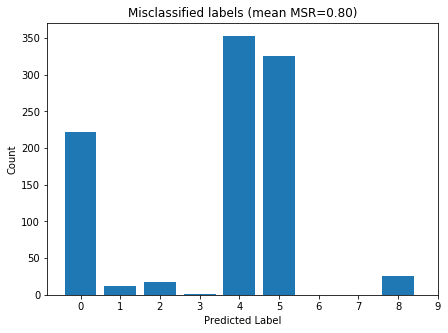

In [9]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all == label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = get_y_pred_labels(y_pred, label_to_remove, background=False)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label, return_counts=True)

# visualization
plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Misclassified labels (mean MSR=%.2f)" % np.mean(get_acc_net_msr(y_pred)))
plt.savefig("../Figures/MNIST/Pred_count/pred-count_wo_cl" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [10]:
# Avarage certitude for unseen class: 1-max_margin
c = get_acc_net_max_margin(y_pred)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean * 100))
print("Std accuracy: %.2f %%" % (pred_acc_std * 100))

pred_acc_high = .95

pct = np.round(len(c[c > pred_acc_high]) / len(c), 4) * 100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 66.68 %
Std accuracy: 31.19 %
25.16% of all predictions made with an accuracy higher than 0.95%


In [11]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = get_y_pred_labels(y_pred_seen, label_to_remove, background=False)

c = get_acc_net_max_margin(y_pred_seen)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean * 100))
print("Std accuracy: %.2f %%" % (pred_acc_std * 100))

pred_acc_high = .95

pct = np.round(len(c[c > pred_acc_high])/len(c), 4) * 100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 98.38 %
Std accuracy: 8.91 %
95.43 % of all predictions made with an accuracy higher than 0.95%


## Network accuracy

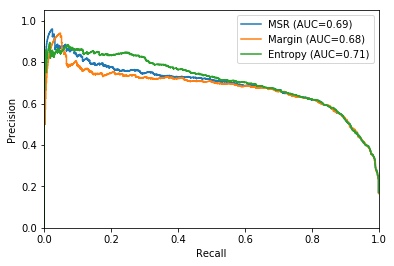

In [12]:
# precision-recall curves

# msr
y_scores = 1-get_acc_net_msr(y_pred_te)
y_true = pred_f_te
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = 1-get_acc_net_max_margin(y_pred_te)
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = 1-get_acc_net_entropy(y_pred_te)
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin, precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)' % pr_auc_msr),
            str.format('Margin (AUC=%.2f)' % pr_auc_margin),
            str.format('Entropy (AUC=%.2f)' % pr_auc_entropy)])

# Dropout

In [13]:
y_preds = predict_with_dropouts_batch(model, x_test_all, 
                                      batch_size=100, n_iter=5)

100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


In [14]:
y_pred = np.mean(y_preds, axis=0)
probas = -get_acc_net_entropy(y_pred)

In [15]:
# Metrics
# PR
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, probas)
pr_auc_dropout = metrics.auc(recall_dropout, precision_dropout)
# ROC
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, probas)
auroc_dropout = metrics.roc_auc_score(y_true, probas)

# Activation weights visualization

(1, 1, 24, 24, 64)


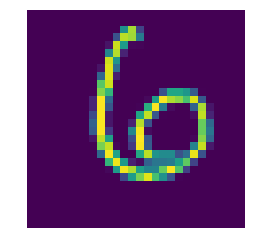

In [16]:
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:, :, 0])
plt.axis('off')
plt.show()

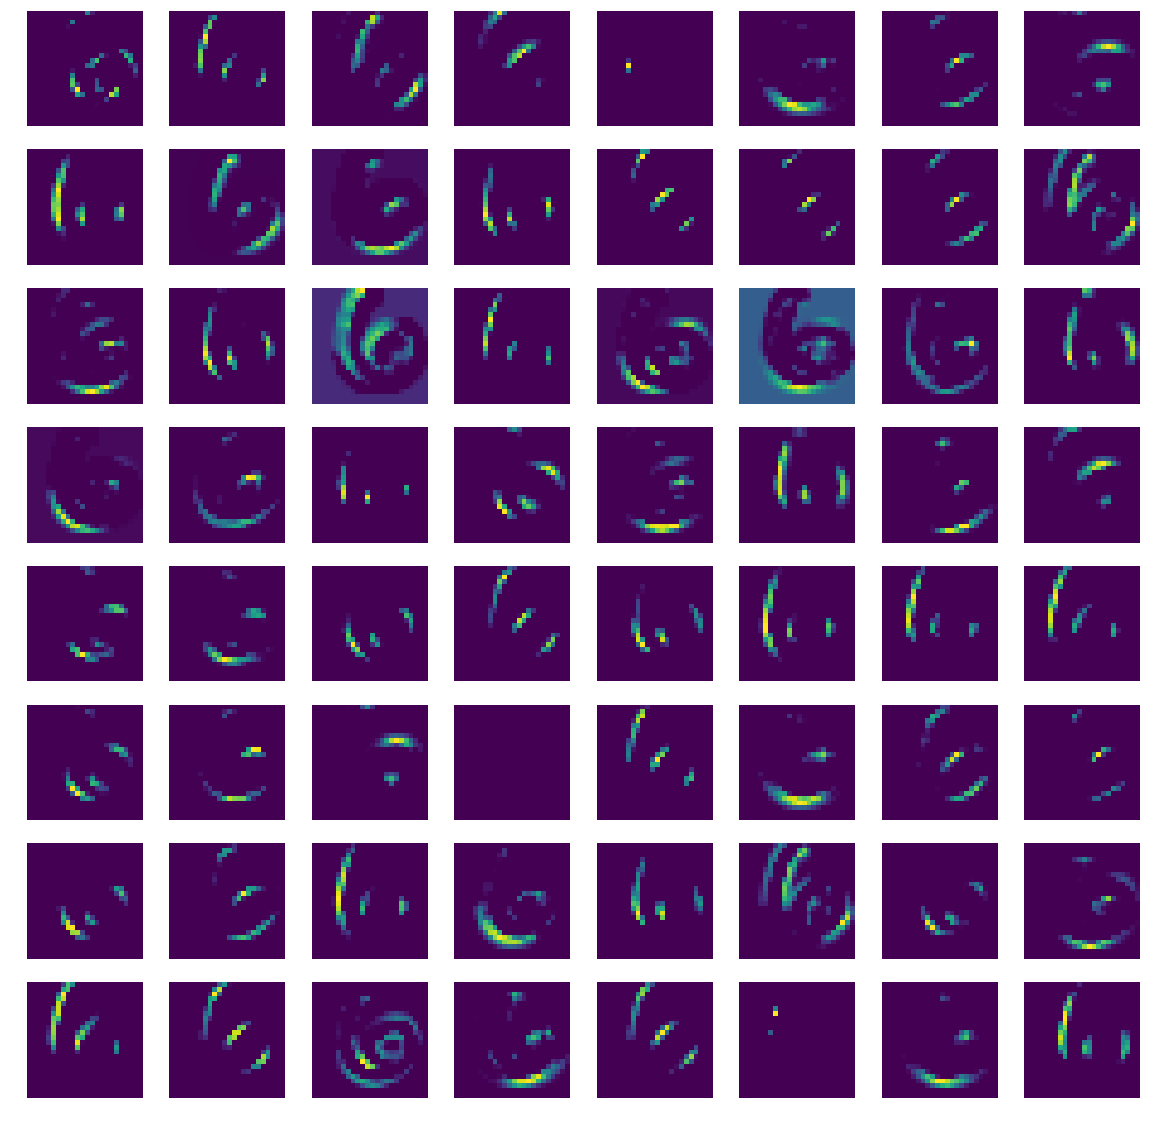

In [17]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(20, 20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:, :, i * 8 + j])
        axes[i][j].set_axis_off()
plt.show()

# Density Forest
## Get Activations, PCA, t-SNE

In [18]:
# get activation weights of last layer
act_unseen = get_activations(model, 6, x_unseen_class)[0]
print(np.shape(act_unseen))

act_train_all = get_activations_batch(model, 6, x_train_all[..., np.newaxis], 20, verbose=True)
print(np.shape(act_train_all))

act_train = act_train_all[y_train_all != label_to_remove]
print(np.shape(act_train))


act_test = get_activations(model, 6, x_test_all)[0]
print(np.shape(act_test))

  0%|          | 1/3000 [00:00<05:44,  8.72it/s]

(958, 128)


100%|██████████| 3000/3000 [00:05<00:00, 573.59it/s]


(60000, 128)
(54082, 128)
(10000, 128)


In [19]:
pts_per_class = 300
n_classes = 10
dataset_subset_indices = get_balanced_subset_indices(y_test_all, np.arange(n_classes), pts_per_class)

In [20]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization after PCA
# tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

In [21]:
# color scale and legend for t-sne plots
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))[:, :3]
names = ['Class ' + str(i) for i in range(10)]
classes_to_keep = np.asarray([x for x in range(n_classes) if x != label_to_remove])

# plot
tsne_y = y_test_all[np.concatenate(dataset_subset_indices)]

Variance explained by first 15 components: 0.88


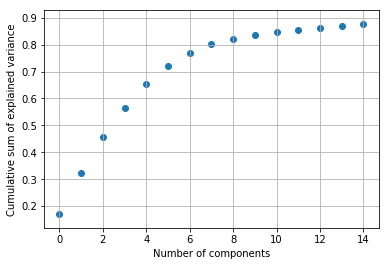

In [22]:
# PCA
n_components = 15
pca = decomposition.PCA(n_components=n_components)
pca.fit(act_train)

# plot
print("Variance explained by first %i components: %.2f" % (n_components, 
                                                           np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/MNIST/PCA/pca_components_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [23]:
# fit PCA
X_train_all = pca.transform(act_train_all)
X_train = pca.transform(act_train)
X_test = pca.transform(act_test)

#### Visualize PCA

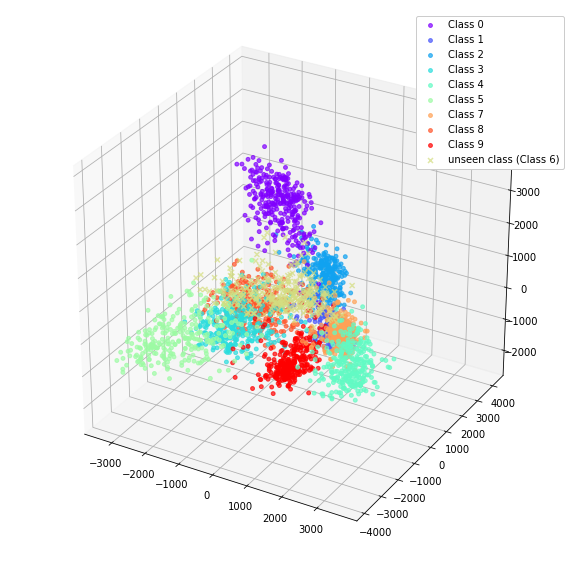

In [24]:
# test sample (with unseen class)
plot_pts_3d(X_train_all, y_train_all, classes_to_keep, names, colors, class_to_remove=label_to_remove, 
            subsample_pct=.05, s_name="../Figures/MNIST/PCA/MINST_PCA_3D_wo_cl_" + str(label_to_remove) + ".pdf")

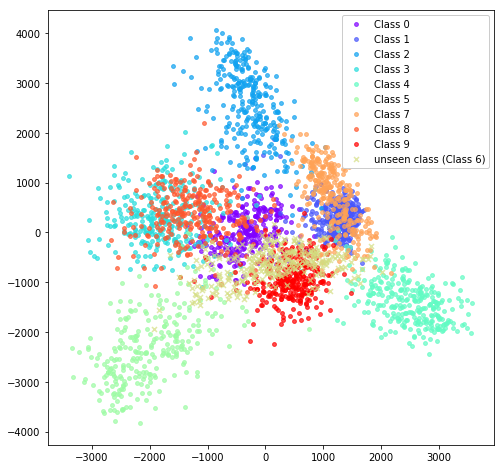

In [25]:
# test sample (with unseen class)
plt, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(X_train_all, y_train_all, ax, classes_to_keep, names, colors, class_to_remove=label_to_remove, 
            subsample_pct=.05)
plt.savefig("../Figures/MNIST/PCA/ MINST_PCA_2D_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [26]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 1.891s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.418695
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.193436
[t-SNE] Error after 300 iterations: 2.680515


In [27]:
import matplotlib.pyplot as plt

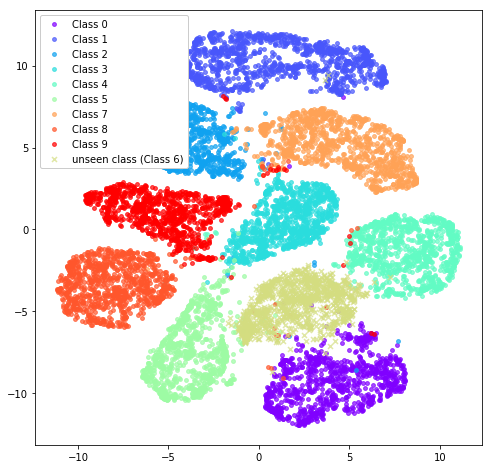

In [28]:
# plot
_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(tsne_all, y_test_all, ax, classes_to_keep, names,
            colors, class_to_remove=label_to_remove)

plt.savefig("../Figures/MNIST/tSNE/MINST_t-SNE_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [29]:
tsne_train = tsne_all[y_test_all != label_to_remove]

### GMM
GMM, calculate 

In [30]:
tuned_parameters = [{'n_components': np.arange(4, 10), 
                     'max_iter': [10000]}]

# do parameter search
ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, X_train, X_train_all, 
                         pred_f_tr[y_train_all < np.infty], scorer_roc_probas_gmm, 
                         n_iter=3, verbosity=11, n_jobs=1, subsample_train=.05, subsample_test=.05)
ps_gmm.fit()

Trying parameters: {'max_iter': 10000, 'n_components': 4}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 5}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 6}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 7}


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 8}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 9}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.9s finished


In [31]:
print(ps_gmm.best_params)

{'max_iter': 10000, 'n_components': 5}


In [32]:
# fit model
gmm = GaussianMixture(**ps_gmm.best_params)
gmm.fit(X_test)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [33]:
# predict
probas = gmm.predict_proba(X_test)
probas = get_acc_net_entropy(probas)

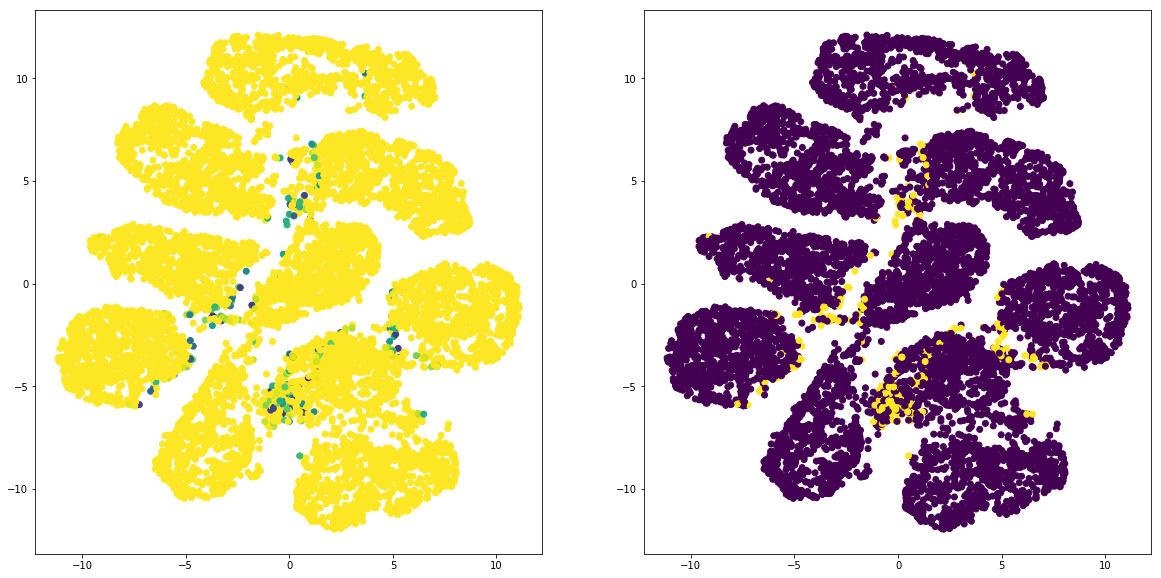

In [34]:
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0], tsne_all[:, 1], c=probas)  # certainty for each point
axes[1].scatter(tsne_all[:, 0], tsne_all[:, 1], c=probas < np.sort(probas)[300])  # 300 least certain points in yellow

In [35]:
# Metrics
# PR
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, -probas)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, -probas)
auroc_gmm = metrics.roc_auc_score(y_true, -probas)

print("PR AUC: %.2f, AUROC: %.2f" % (pr_auc_gmm, auroc_gmm))

PR AUC: 0.40, AUROC: 0.89


## One-Class SVM

In [36]:
X_train_svm = preprocessing.scale(X_train)
X_train_all_svm = preprocessing.scale(X_train_all)
X_test_svm = preprocessing.scale(X_test)

/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [37]:
y_true_tr = (y_train_all != y_pred_label_tr) * 1

tuned_parameters = [{'kernel': ['rbf'],
                     'nu': [1e-2, .1, .3, .5]
                     },
                    {'kernel': ['poly'],
                     'degree': np.arange(1, 16),
                     'nu': [1e-2, .1, .3, .5],
                     'max_iter': [10000]
                     }]

# do parameter search
ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, X_train_svm, X_train_all_svm, 
                         pred_f_tr[y_train_all < np.infty], scorer_roc_probas_svm, n_iter=5, 
                         verbosity=10, n_jobs=-1, subsample_train=.1, subsample_test=.1)

ps_svm.fit()

Trying parameters: {'kernel': 'rbf', 'nu': 0.01}
Trying parameters: {'kernel': 'rbf', 'nu': 0.1}
Trying parameters: {'kernel': 'rbf', 'nu': 0.3}
Trying parameters: {'kernel': 'rbf', 'nu': 0.5}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu':

[Parallel(n_jobs=40)]: Done   6 out of  64 | elapsed:    3.3s remaining:   31.7s


Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=40)]: Done  13 out of  64 | elapsed:    5.2s remaining:   20.2s


Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=40)]: Done  20 out of  64 | elapsed:    7.4s remaining:   16.3s


Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  27 out of  64 | elapsed:    8.5s remaining:   11.6s
[Parallel(n_jobs=40)]: Done  34 out of  64 | elapsed:   12.7s remaining:   11.2s
[Parallel(n_jobs=40)]: Done  41 out of  64 | elapsed:   15.1s remaining:    8.5s
[Parallel(n_jobs=40)]: Done  48 out of  64 | elapsed:   17.6s remaining:    5.9s
[Parallel(n_jobs=40)]: Done  55 out of  64 | elapsed:   19.4s remaining:    3.2s
[Parallel(n_jobs=40)]: Done  62 out of  64 | elapsed:   22.1s remaining:    0.7s
[Parallel(n_jobs=40)]: Done  64 out of  64 | elapsed:   23.6s finished


In [38]:
print(ps_svm.best_params)

{'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


In [39]:
clf_svm = svm.OneClassSVM(**ps_svm.best_params, verbose=True)

In [40]:
clf_svm.fit(X_train_svm)

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=15, gamma='auto', kernel='poly',
      max_iter=10000, nu=0.01, random_state=None, shrinking=True,
      tol=0.001, verbose=True)

In [41]:
probas = clf_svm.decision_function(X_test_svm)[:, 0]
probas -= np.min(probas)
probas /= np.max(probas)

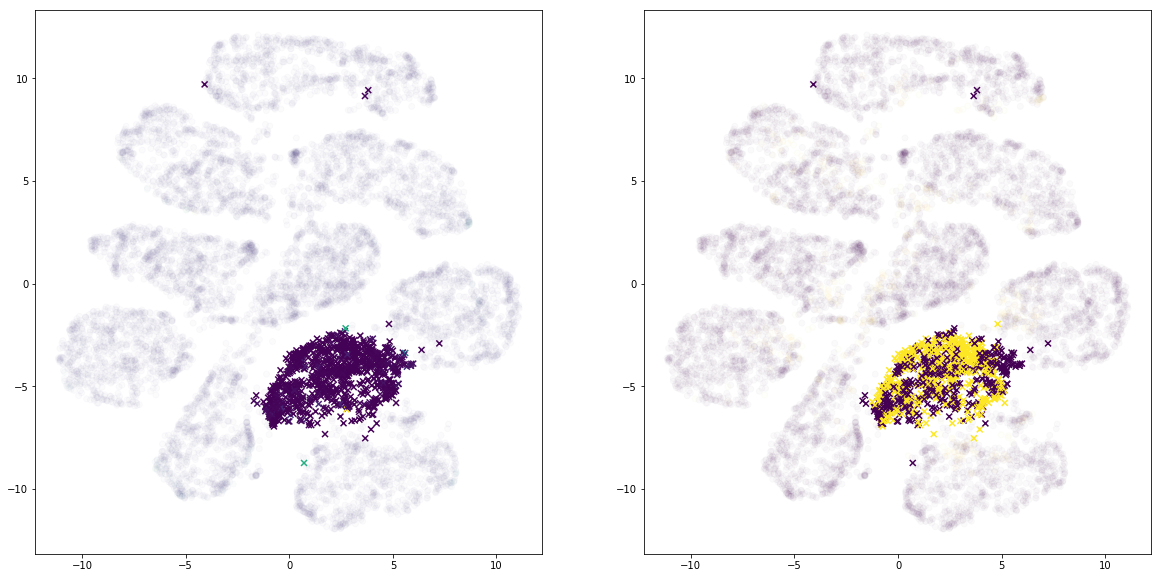

In [42]:
# plot correctly / incorrectly predicted points (x/o marker)
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t_te], tsne_all[:, 1][pred_t_te], c=probas[pred_t_te], alpha=.02)
axes[1].scatter(tsne_all[:, 0][pred_t_te], tsne_all[:, 1][pred_t_te], 
                c=(probas < np.sort(probas)[1000])[pred_t_te], alpha=.02)

# plot correctly / incorrectly predicted points (x/o marker)
axes[0].scatter(tsne_all[:, 0][pred_f_te], tsne_all[:, 1][pred_f_te], c=probas[pred_f_te], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f_te], tsne_all[:, 1][pred_f_te], 
                c=(probas < np.sort(probas)[1000])[pred_f_te], marker='x')

In [43]:
# Metrics
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, -probas)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)
# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, -probas)
auroc_svm = metrics.roc_auc_score(y_true, -probas)

print("PR AUC: %.2f, AUROC: %.2f" % (pr_auc_svm, auroc_svm))

PR AUC: 0.50, AUROC: 0.89


# Density Forest

In [66]:
default_params = {'min_subset': .05, 'n_trees': 30, 'n_max_dim': 1, 'n_jobs': -1, 'subsample_pct': .02, 'verbose': 0}


tuned_params = [{'max_depth': [2, 4, 5],
                 'ig_improvement': [0, .3, .5, .7, .9]}]

In [70]:
ps_df = ParameterSearch(DensityForest, tuned_params, X_train, X_train_all,
                        pred_f_tr[y_train_all < np.infty], scorer_roc_probas_df, n_iter=3,
                        verbosity=11, n_jobs=1, subsample_train=1, subsample_test=1, default_params=default_params)

ps_df.fit()

Trying parameters: {'ig_improvement': 0, 'max_depth': 2, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 4, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 5, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.9min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.3, 'max_depth': 2, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 13.0min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.3, 'max_depth': 4, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.2min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.3, 'max_depth': 5, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 19.2min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.5, 'max_depth': 2, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 20.8min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.5, 'max_depth': 4, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 23.2min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.5, 'max_depth': 5, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 25.6min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 2, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 27.6min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 4, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.7, 'max_depth': 5, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.9, 'max_depth': 2, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.9, 'max_depth': 4, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.9, 'max_depth': 5, 'min_subset': 0.05, 'n_jobs': -1, 'n_max_dim': 1, 'n_trees': 30, 'subsample_pct': 0.02, 'verbose': 0}


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 38.9min finished


In [71]:
print(ps_df.best_params)

{'ig_improvement': 0.9, 'max_depth': 5}


In [72]:
display(ps_df.results_df.groupby('max_depth').mean())
display(ps_df.results_df.groupby('ig_improvement').mean())

,ig_improvement,result,std
max_depth,,,
2.0,0.48,0.802066,0.055658
4.0,0.48,0.870854,0.030678
5.0,0.48,0.867703,0.031401


,max_depth,result,std
ig_improvement,,,
0.0,3.666667,0.841164,0.039600
0.3,3.666667,0.844264,0.054748
0.5,3.666667,0.845819,0.034135
0.7,3.666667,0.835258,0.021993
0.9,3.666667,0.867868,0.045754


In [73]:
default_params['verbose'] = 1
#default_params['n_trees'] = 30

In [74]:
# Create DensityForest instance
clf_df = DensityForest(**ps_df.best_params, **default_params)

In [75]:
clf_df.fit(X_train)

Number of points on which to train each tree: 1081
Minimum number of points in each leaf: 54


[Parallel(n_jobs=40)]: Done  13 out of  30 | elapsed:    1.4s remaining:    1.9s
[Parallel(n_jobs=40)]: Done  30 out of  30 | elapsed:    7.4s finished


Number of created root nodes: 15
Mean number of clusters created per tree: 8


In [76]:
probas = clf_df.predict(X_test)

In [77]:
covs, means = get_clusters(clf_df.root_nodes[1], [], [])

0.24596563367104668

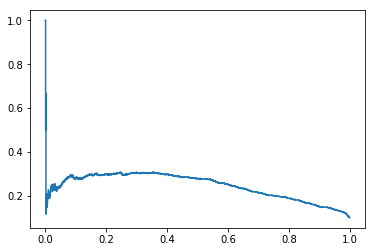

In [78]:
# precision-recall curve
y_scores = -probas
# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)
# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_df, precision_df)
metrics.auc(recall_df, precision_df)

## Plot Results

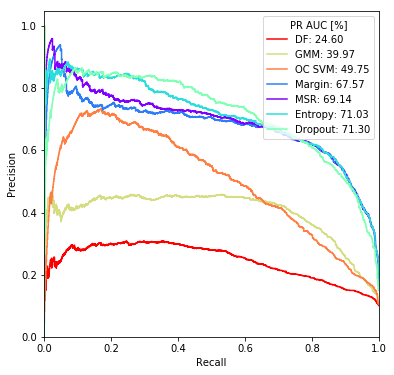

In [79]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = np.multiply([pr_auc_msr, pr_auc_margin, pr_auc_entropy, 
                         pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df], 100)

recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, 
              precision_dropout, precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC [%]")
plt.savefig("../Figures/MNIST/Metrics/PR_ED_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

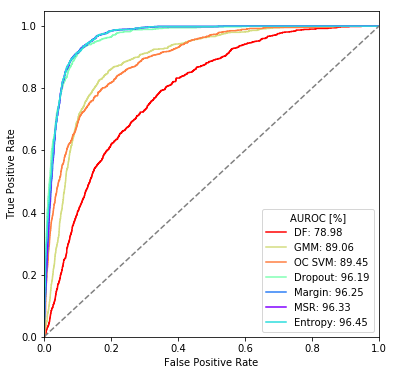

In [80]:
# ROC
# order according to increasing score
scores_auc = np.multiply([auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df], 100)
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC [%]")
plt.savefig("../Figures/MNIST/Metrics/ROC_ED_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()